### Test Rasterizer

In [36]:
from glob import glob
import math
import torch
from scene import Scene
import os
import sys
import numpy as np
from tqdm import tqdm
from os import makedirs
from gaussian_renderer import render
import torchvision
from argparse import ArgumentParser, Namespace
from plyfile import PlyData, PlyElement

from utils.general_utils import safe_state
from utils.graphics_utils import getWorld2View2, getWorld2View, getProjectionMatrix
from arguments import ModelParams, PipelineParams, OptimizationParams, get_combined_args
from gaussian_renderer import GaussianModel

# Set up command line argument parser
parser = ArgumentParser(description="Testing script parameters")
model = ModelParams(parser, sentinel=True)
op = OptimizationParams(parser)
pipeline = PipelineParams(parser)
parser.add_argument("--iteration", default=-1, type=int)
parser.add_argument("--skip_train", action="store_true")
parser.add_argument("--skip_test", action="store_true")
parser.add_argument("--quiet", action="store_true")

args_cmdline = parser.parse_args(args=[
    "--model_path",
    #"/home/hjp/gaussian_models/train",
    #"/home/hjp/gaussian_models/bonsai",
    #"/home/hjp/gaussian-splatting/output/45f70d99-a",
    "/home/youngdong/gaussian_models/flowers",
    
    "--source_path",
    #"/home/hjp/dataset/tandt/train/",
    #"/home/hjp/dataset/mipnerf360/bonsai"
    "/home/hjp/dataset/flowers",
])

cfgfile_string = "Namespace()"
try:
    cfgfilepath = os.path.join(args_cmdline.model_path, "cfg_args")
    print("Looking for config file in", cfgfilepath)
    with open(cfgfilepath) as cfg_file:
        print("Config file found: {}".format(cfgfilepath))
        cfgfile_string = cfg_file.read()
except TypeError:
    print("Config file not found at")
    pass
print("Config file arguments: ", cfgfile_string)

args_cfgfile = eval(cfgfile_string)

merged_dict = vars(args_cfgfile).copy()
for k,v in vars(args_cmdline).items():
    if v != None:
        merged_dict[k] = v
args = Namespace(**merged_dict)

assert os.path.exists(args.model_path), "Model path does not exist"
assert os.path.exists(args.source_path), "Source path does not exist"

model_args = model.extract(args)
optim_args = op.extract(args)
pipe_args = pipeline.extract(args)

print(model_args.resolution)

Looking for config file in /home/youngdong/gaussian_models/flowers/cfg_args
Config file found: /home/youngdong/gaussian_models/flowers/cfg_args
Config file arguments:  Namespace(data_device='cuda', eval=True, images='images', model_path='/home/jang/models/flowers/', resolution=-1, sh_degree=3, source_path='/home/jang/dataset/flowers', white_background=False)
-1


In [37]:
model_args.data_device = "cuda"

# GaussianModel 초기화
gaussians = GaussianModel(model_args.sh_degree)
scene = Scene(
    model_args, gaussians, 
    load_iteration = args.iteration, shuffle = False
)
#gaussians.training_setup(optim_args)

MODEL_PATH = model_args.model_path
out_pcd_path = os.path.join(
    MODEL_PATH,
    "point_cloud/iteration_30000/point_cloud.ply"
)

ply_data = PlyData.read(out_pcd_path)

xyz = np.stack((
    np.asarray(ply_data.elements[0]["x"]),
    np.asarray(ply_data.elements[0]["y"]),
    np.asarray(ply_data.elements[0]["z"])),
    axis=1
)

opacities = np.asarray(ply_data.elements[0]["opacity"])[..., np.newaxis]

features_dc = np.zeros((xyz.shape[0], 3, 1))
features_dc[:, 0, 0] = np.asarray(ply_data.elements[0]["f_dc_0"])
features_dc[:, 1, 0] = np.asarray(ply_data.elements[0]["f_dc_1"])
features_dc[:, 2, 0] = np.asarray(ply_data.elements[0]["f_dc_2"])

extra_f_names = [p.name for p in ply_data.elements[0].properties if p.name.startswith("f_rest_")]
extra_f_names = sorted(extra_f_names, key = lambda x: int(x.split('_')[-1]))

max_sh_degree = int(math.sqrt((len(extra_f_names) + 3) // 3) - 1)
assert len(extra_f_names)==3*(max_sh_degree + 1) ** 2 - 3
features_extra = np.zeros((xyz.shape[0], len(extra_f_names)))
for idx, attr_name in enumerate(extra_f_names):
    features_extra[:, idx] = np.asarray(ply_data.elements[0][attr_name])
# Reshape (P,F*SH_coeffs) to (P, F, SH_coeffs except DC)

features_extra = features_extra.reshape((features_extra.shape[0], 3, (max_sh_degree + 1) ** 2 - 1))

scale_names = [p.name for p in ply_data.elements[0].properties if p.name.startswith("scale_")]
scale_names = sorted(scale_names, key = lambda x: int(x.split('_')[-1]))
scales = np.zeros((xyz.shape[0], len(scale_names)))
for idx, attr_name in enumerate(scale_names):
    scales[:, idx] = np.asarray(ply_data.elements[0][attr_name])

rot_names = [p.name for p in ply_data.elements[0].properties if p.name.startswith("rot")]
rot_names = sorted(rot_names, key = lambda x: int(x.split('_')[-1]))
rots = np.zeros((xyz.shape[0], len(rot_names)))
for idx, attr_name in enumerate(rot_names):
    rots[:, idx] = np.asarray(ply_data.elements[0][attr_name])

Loading trained model at iteration 30000
Reading camera 173/173
Loading Training Cameras
Loading Test Cameras


In [39]:
gaussians._xyz.shape

torch.Size([3636448, 3])

## render() 함수 리턴값 조사
- "render" : 렌더링된 이미지
- "viewspace_points" : "train" 씬의 경우, 전부 0으로 나옴.
- "visibility_filter" : 
- "radii" : 

In [38]:
bg_color = [1,1,1] if model_args.white_background else [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

camera = scene.getTrainCameras()[0]

#gaussians.optimizer.zero_grad(set_to_none = True)
render_pkg = render(
    camera, gaussians, pipe_args, background
)
render_pkg.keys()

dict_keys(['render', 'viewspace_points', 'visibility_filter', 'radii'])

#### visibility filter 

In [6]:
render_pkg["radii"]

tensor([8, 4, 3,  ..., 0, 0, 0], device='cuda:0', dtype=torch.int32)

In [59]:
render_pkg["visibility_filter"]

tensor([ True,  True,  True,  ..., False, False, False], device='cuda:0')

In [63]:
render_pkg["viewspace_points"].sum().item()

0.0

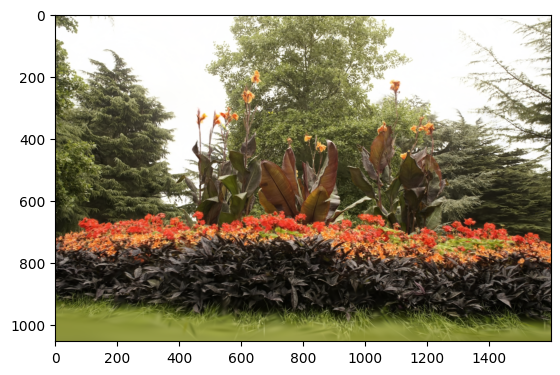

In [40]:
import matplotlib.pyplot as plt

plt.imshow(
    render_pkg["render"].detach().cpu().clamp(0, 1).numpy().transpose(1,2,0)
)

In [42]:
'''
for is_viewed, xyz_grad, scale_grad in zip(
    render_pkg["visibility_filter"],
    gaussians._xyz.grad,
    gaussians._scaling.grad
) :
    print(is_viewed.item(), xyz_grad.detach().cpu().numpy(), scale_grad.detach().cpu().numpy())
'''

'\nfor is_viewed, xyz_grad, scale_grad in zip(\n    render_pkg["visibility_filter"],\n    gaussians._xyz.grad,\n    gaussians._scaling.grad\n) :\n    print(is_viewed.item(), xyz_grad.detach().cpu().numpy(), scale_grad.detach().cpu().numpy())\n'

In [10]:
render_pkg["visibility_filter"].shape, gaussians._xyz.shape

(torch.Size([1070179]), torch.Size([1070179, 3]))

In [11]:
import numpy as np

camera_direction_v = camera.R @ np.array([0,0,1])
camera.T, camera.R, camera_direction_v

(array([2.52041501, 0.44506305, 4.56443097]),
 array([[ 9.87094666e-01,  1.17542690e-02,  1.59705847e-01],
        [-4.81623212e-04,  9.97515909e-01, -7.04398923e-02],
        [-1.60137093e-01,  6.94539239e-02,  9.84648295e-01]]),
 array([ 0.15970585, -0.07043989,  0.98464829]))

In [63]:

import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

# Suppose you have the following lists of camera positions and directions

train_camera_list = scene.getTrainCameras()
camera_position_array = np.array(list(map(
    lambda cam: np.linalg.inv(getWorld2View2(cam.R, cam.T))[:3, 3:4].copy(),
    train_camera_list
))).reshape(-1, 3)
#camera_facing_v_array = np.array(list(map(lambda x: x.R @ np.array([0,0,1]), train_camera_list)))
camera_x_array = np.array(list(map(lambda x: x.R @ np.array([1,0,0]), train_camera_list)))
camera_y_array = np.array(list(map(lambda x: x.R @ np.array([0,1,0]), train_camera_list)))
camera_z_array = np.array(list(map(lambda x: x.R @ np.array([0,0,1]), train_camera_list)))

# Create a figure
fig = go.Figure()

# Add cones or arrows to represent the camera directions
for position, direction in zip(camera_position_array, camera_z_array):
    norm = (direction[0]**2 + direction[1]**2 + direction[2]**2)**0.5
    fig.add_trace(go.Cone(
        x=[position[0]],
        y=[position[1]],
        z=[position[2]],
        u=[direction[0]/norm],
        v=[direction[1]/norm],
        w=[direction[2]/norm],
        colorscale=[[0, 'blue'], [1, 'blue']],
        sizemode="absolute",
        sizeref=0.1,
        anchor="tail",
    ))


for position, direction in zip(camera_position_array, camera_x_array):
    norm = (direction[0]**2 + direction[1]**2 + direction[2]**2)**0.5
    fig.add_trace(go.Cone(
        x=[position[0]],
        y=[position[1]],
        z=[position[2]],
        u=[direction[0]/norm],
        v=[direction[1]/norm],
        w=[direction[2]/norm],
        colorscale=[[0, 'red'], [1, 'red']],
        sizemode="absolute",
        sizeref=0.1,
        anchor="tail"
    ))

for position, direction in zip(camera_position_array, camera_y_array):
    norm = (direction[0]**2 + direction[1]**2 + direction[2]**2)**0.5
    fig.add_trace(go.Cone(
        x=[position[0]],
        y=[position[1]],
        z=[position[2]],
        u=[direction[0]/norm],
        v=[direction[1]/norm],
        w=[direction[2]/norm],
        colorscale=[[0, 'green'], [1, 'green']],
        sizemode="absolute",
        sizeref=0.1,
        anchor="tail"
    ))



# Set the layout for the 3D plot
fig.update_layout(
    scene=dict(
        xaxis=dict(title='X Axis'),
        yaxis=dict(title='Y Axis'),
        zaxis=dict(title='Z Axis'),
        aspectratio=dict(x=1, y=1, z=1)
    ),
    title='Camera Positions and Orientations'
)
fig.update_scenes(aspectmode='data')

# Plot the figure
pyo.plot(fig)

iplot(fig)


In [64]:
# plot every points and cameras

init_notebook_mode(connected=True)

X, Y, Z = xyz[::1000, :].T
colors = features_dc[::1000].reshape(-1, 3)

colors_formatted = list(map(
    lambda raw :  f"rgb({int(raw[0] * 255)}, {int(raw[1] * 255)}, {int(raw[2] * 255)})",
    colors
))

trace = go.Scatter3d(
    x=X,
    y=Y,
    z=Z,
    mode='markers',
    marker=dict(
        size=1 ,  # Change the size s]of markers here
        #color=colors_formatted,  # Set color to the Z coordinate for depth effect
        #color = Z,
        #colorscale='Viridis',  # Choose a color scale
        opacity=0.8
    )
)

layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0)
)

fig = go.Figure(data=[trace], layout=layout)


train_camera_list = scene.getTrainCameras()
camera_position_array = np.array(list(map(
    lambda cam: np.linalg.inv(getWorld2View2(cam.R, cam.T))[:3, 3:4].copy(),
    train_camera_list
))).reshape(-1, 3)
camera_facing_v_array = np.array(list(map(lambda x: x.R @ np.array([0,0,1]), train_camera_list)))

# Add cones or arrows to represent the camera directions
for position, direction in zip(camera_position_array, camera_facing_v_array):
    norm = (direction[0]**2 + direction[1]**2 + direction[2]**2)**0.5
    fig.add_trace(go.Cone(
        x=[position[0]],
        y=[position[1]],
        z=[position[2]],
        u=[direction[0]/norm],
        v=[direction[1]/norm],
        w=[direction[2]/norm],
        sizemode="absolute",
        sizeref=0.2,
        anchor="tail")
    )




fig.update_scenes(aspectmode='data')

# Render the plot
pyo.plot(fig)
iplot(fig)


In [46]:
# calculate angle between camera heading and cameera->point vector
# for every point 

CAM_IDX = 0
ANGLE_THRESH = 0.4


camera = scene.getTrainCameras()[CAM_IDX]

cam_center = np.linalg.inv(getWorld2View2(camera.R, camera.T))[:3, 3:4].copy().reshape(-1)
cam_facing_v = camera.R @ np.array([0,0,1])

angle = np.arccos(np.dot(
    cam_facing_v.reshape(1, 3),
    (
        (xyz - cam_center) / np.linalg.norm(xyz - cam_center, axis=1, keepdims=True)
    ).T
)).reshape(-1)

In [48]:
# calculate angle between camera heading and cameera->point vector
# for every points

# plot single camera and points filtered by angle per camera
#

init_notebook_mode(connected=True)

CAM_IDX = 1
ANGLE_THRESH = 0.2

camera = scene.getTrainCameras()[CAM_IDX]

cam_center = np.linalg.inv(getWorld2View2(camera.R, camera.T))[:3, 3:4].copy().reshape(-1)
cam_facing_v = camera.R @ np.array([0,0,1])

angle = np.arccos(np.dot(
    cam_facing_v.reshape(1, 3),
    (
        (xyz - cam_center) / np.linalg.norm(xyz - cam_center, axis=1, keepdims=True)
    ).T
)).reshape(-1)
cone_angle_mask = (angle < ANGLE_THRESH) & (angle > -ANGLE_THRESH)

X_filtered, Y_filtered, Z_filtered = xyz[cone_angle_mask][::100].T
X_left, Y_left, Z_left = xyz[~cone_angle_mask][::1000].T

trace_inside_angle = go.Scatter3d(
    x=X_filtered, y=Y_filtered, z=Z_filtered,
    mode='markers',
    marker=dict(size=1, color = "blue", opacity=0.8)
)
trace_outside_angle = go.Scatter3d(
    x=X_left, y=Y_left, z=Z_left,
    mode='markers',
    marker=dict(size=1, color = "red", opacity=0.8)
)

layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0)
)

fig = go.Figure(data=[trace_inside_angle, trace_outside_angle], layout=layout)

train_camera_list = scene.getTrainCameras()
camera_position_array = np.array(list(map(
    lambda cam: np.linalg.inv(getWorld2View2(cam.R, cam.T))[:3, 3:4].copy(),
    train_camera_list
))).reshape(-1, 3)
camera_facing_v_array = np.array(list(map(lambda x: x.R @ np.array([0,0,1]), train_camera_list)))

position = camera_position_array[CAM_IDX]
direction = camera_facing_v_array[CAM_IDX]
fig.add_trace(go.Cone(
    x=[position[0]],
    y=[position[1]],
    z=[position[2]],
    u=[direction[0]/norm],
    v=[direction[1]/norm],
    w=[direction[2]/norm],
    sizemode="absolute",
    sizeref=0.2,
    anchor="tail")
)

fig.update_scenes(aspectmode='data')

# Render the plot
pyo.plot(fig)
iplot(fig)

/tmp/ipykernel_2399767/123173456.py:17: RuntimeWarning:

invalid value encountered in arccos



In [ ]:
# code for getting cone angle mask

CAM_IDX = 1
ANGLE_THRESH = 0.3

camera = scene.getTrainCameras()[CAM_IDX]
cam_center = np.linalg.inv(getWorld2View2(camera.R, camera.T))[:3, 3:4].copy().reshape(-1)

cam_basis_x = camera.R @ np.array([1,0,0])
cam_basis_y = camera.R @ np.array([0,1,0])
cam_basis_z = camera.R @ np.array([0,0,1])

center_to_points_norm = (xyz - cam_center) / np.linalg.norm(xyz - cam_center, axis=1, keepdims=True)

center_to_points_x = 

angle = np.arccos(np.dot(
    cam_facing_v.reshape(1, 3),
    (
        (xyz - cam_center) / np.linalg.norm(xyz - cam_center, axis=1, keepdims=True)
    ).T
)).reshape(-1)

cone_angle_mask = (angle < ANGLE_THRESH) & (angle > -ANGLE_THRESH)

In [39]:
# code for getting pyramid angle mask

CAM_IDX = 1

camera = scene.getTrainCameras()[CAM_IDX]
cam_center = np.linalg.inv(
    getWorld2View2(camera.R, camera.T)
)[:3, 3:4].copy().reshape(-1)
cam_basis_x = camera.R @ np.array([1,0,0])
cam_basis_y = camera.R @ np.array([0,1,0])
cam_basis_z = camera.R @ np.array([0,0,1])

point_displacement_cam_basis_x_component = np.dot(xyz - cam_center, cam_basis_x).reshape(-1, 1) * cam_basis_x.reshape(1, 3)
point_displacement_cam_basis_y_component = np.dot(xyz - cam_center, cam_basis_y).reshape(-1, 1) * cam_basis_y.reshape(1, 3)
point_displacement_cam_basis_z_component = np.dot(xyz - cam_center, cam_basis_z).reshape(-1, 1) * cam_basis_z.reshape(1, 3)

point_displacement_cam_xz_proj = point_displacement_cam_basis_x_component + point_displacement_cam_basis_z_component
point_displacement_cam_yz_proj = point_displacement_cam_basis_y_component + point_displacement_cam_basis_z_component

x_dir_angle_arr = np.arccos(
    np.dot(point_displacement_cam_xz_proj, cam_basis_z) / (np.linalg.norm(point_displacement_cam_xz_proj, axis=1))
)
y_dir_angle_arr = np.arccos(
    np.dot(point_displacement_cam_yz_proj, cam_basis_z) / (np.linalg.norm(point_displacement_cam_yz_proj, axis=1))
)

x_dir_mask = np.abs(x_dir_angle_arr) < (camera.FoVx / 2)
y_dir_mask = np.abs(y_dir_angle_arr) < (camera.FoVy / 2)
angle_mask = x_dir_mask & y_dir_mask

In [56]:
init_notebook_mode(connected=True)
CAM_IDX = 100

camera = scene.getTrainCameras()[CAM_IDX]
cam_center = np.linalg.inv(
    getWorld2View2(camera.R, camera.T)
)[:3, 3:4].copy().reshape(-1)
cam_basis_x = camera.R @ np.array([1,0,0])
cam_basis_y = camera.R @ np.array([0,1,0])
cam_basis_z = camera.R @ np.array([0,0,1])

point_displacement_cam_basis_x_component = np.dot(xyz - cam_center, cam_basis_x).reshape(-1, 1) * cam_basis_x.reshape(1, 3)
point_displacement_cam_basis_y_component = np.dot(xyz - cam_center, cam_basis_y).reshape(-1, 1) * cam_basis_y.reshape(1, 3)
point_displacement_cam_basis_z_component = np.dot(xyz - cam_center, cam_basis_z).reshape(-1, 1) * cam_basis_z.reshape(1, 3)

point_displacement_cam_xz_proj = point_displacement_cam_basis_x_component + point_displacement_cam_basis_z_component
point_displacement_cam_yz_proj = point_displacement_cam_basis_y_component + point_displacement_cam_basis_z_component

x_dir_angle_arr = np.arccos(
    np.dot(point_displacement_cam_xz_proj, cam_basis_z) / (np.linalg.norm(point_displacement_cam_xz_proj, axis=1))
)
y_dir_angle_arr = np.arccos(
    np.dot(point_displacement_cam_yz_proj, cam_basis_z) / (np.linalg.norm(point_displacement_cam_yz_proj, axis=1))
)

x_dir_mask = np.abs(x_dir_angle_arr) < (camera.FoVx / 2)
y_dir_mask = np.abs(y_dir_angle_arr) < (camera.FoVy / 2)
angle_mask = x_dir_mask & y_dir_mask

X_inside, Y_inside, Z_inside = xyz[angle_mask][::100].T
X_outside, Y_outside, Z_outside = xyz[~angle_mask][::1000].T

trace_inside_pyramid_angle = go.Scatter3d(
    x=X_inside, y=Y_inside, z=Z_inside,
    mode='markers', marker=dict(size=1, color="blue", opacity=0.8)
)
trace_outside_pyramid_angle = go.Scatter3d(
    x=X_outside, y=Y_outside, z=Z_outside,
    mode='markers', marker=dict(size=1, color="red", opacity=0.8)
)
layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0))
fig = go.Figure(data=[trace_inside_pyramid_angle, trace_outside_pyramid_angle], layout=layout)

train_camera_list = scene.getTrainCameras()
camera_position_array = np.array(list(map(
    lambda cam: np.linalg.inv(getWorld2View2(cam.R, cam.T))[:3, 3:4].copy(),
    train_camera_list
))).reshape(-1, 3)
camera_facing_v_array = np.array(list(map(lambda x: x.R @ np.array([0,0,1]), train_camera_list)))

position = camera_position_array[CAM_IDX]
direction = camera_facing_v_array[CAM_IDX]
fig.add_trace(go.Cone(
    x=[position[0]], y=[position[1]], z=[position[2]],
    u=[direction[0]/norm], v=[direction[1]/norm], w=[direction[2]/norm],
    sizemode="absolute", sizeref=1, anchor="tail")
)
fig.update_scenes(aspectmode='data')

pyo.plot(fig)
iplot(fig)

In [46]:
# get number of points appear on each camera 


point_count_dict = {}


camera_list = scene.getTrainCameras()
for idx, camera in enumerate(camera_list) :
           
    cam_center = np.linalg.inv(
        getWorld2View2(camera.R, camera.T)
    )[:3, 3:4].copy().reshape(-1)
    cam_basis_x = camera.R @ np.array([1,0,0])
    cam_basis_y = camera.R @ np.array([0,1,0])
    cam_basis_z = camera.R @ np.array([0,0,1])

    point_displacement_cam_basis_x_component = np.dot(xyz - cam_center, cam_basis_x).reshape(-1, 1) * cam_basis_x.reshape(1, 3)
    point_displacement_cam_basis_y_component = np.dot(xyz - cam_center, cam_basis_y).reshape(-1, 1) * cam_basis_y.reshape(1, 3)
    point_displacement_cam_basis_z_component = np.dot(xyz - cam_center, cam_basis_z).reshape(-1, 1) * cam_basis_z.reshape(1, 3)

    point_displacement_cam_xz_proj = point_displacement_cam_basis_x_component + point_displacement_cam_basis_z_component
    point_displacement_cam_yz_proj = point_displacement_cam_basis_y_component + point_displacement_cam_basis_z_component

    x_dir_angle_arr = np.arccos(
        np.dot(point_displacement_cam_xz_proj, cam_basis_z) / (np.linalg.norm(point_displacement_cam_xz_proj, axis=1))
    )
    y_dir_angle_arr = np.arccos(
        np.dot(point_displacement_cam_yz_proj, cam_basis_z) / (np.linalg.norm(point_displacement_cam_yz_proj, axis=1))
    )

    x_dir_mask = np.abs(x_dir_angle_arr) < (camera.FoVx / 2)
    y_dir_mask = np.abs(y_dir_angle_arr) < (camera.FoVy / 2)
    angle_mask = x_dir_mask & y_dir_mask
    
    point_count_dict[camera.image_name] = angle_mask.sum()

/tmp/ipykernel_424859/3928094718.py:27: RuntimeWarning:

invalid value encountered in arccos

/tmp/ipykernel_424859/3928094718.py:24: RuntimeWarning:

invalid value encountered in arccos



In [47]:
point_count_array = np.array(list(point_count_dict.values()))

print(point_count_array.mean(), point_count_array.std())


633688.5647840531 168528.61785800513


In [20]:

# get number of points appear on each camera 


whole_info_dict = {}


camera_list = scene.getTrainCameras()
for idx, camera in enumerate(camera_list) :
           
    cam_center = np.linalg.inv(
        getWorld2View2(camera.R, camera.T)
    )[:3, 3:4].copy().reshape(-1)
    cam_basis_x = camera.R @ np.array([1,0,0])
    cam_basis_y = camera.R @ np.array([0,1,0])
    cam_basis_z = camera.R @ np.array([0,0,1])

    point_displacement_cam_basis_x_component = np.dot(xyz - cam_center, cam_basis_x).reshape(-1, 1) * cam_basis_x.reshape(1, 3)
    point_displacement_cam_basis_y_component = np.dot(xyz - cam_center, cam_basis_y).reshape(-1, 1) * cam_basis_y.reshape(1, 3)
    point_displacement_cam_basis_z_component = np.dot(xyz - cam_center, cam_basis_z).reshape(-1, 1) * cam_basis_z.reshape(1, 3)

    point_displacement_cam_xz_proj = point_displacement_cam_basis_x_component + point_displacement_cam_basis_z_component
    point_displacement_cam_yz_proj = point_displacement_cam_basis_y_component + point_displacement_cam_basis_z_component

    x_dir_angle_arr = np.arccos(
        np.dot(point_displacement_cam_xz_proj, cam_basis_z) / (np.linalg.norm(point_displacement_cam_xz_proj, axis=1))
    )
    y_dir_angle_arr = np.arccos(
        np.dot(point_displacement_cam_yz_proj, cam_basis_z) / (np.linalg.norm(point_displacement_cam_yz_proj, axis=1))
    )

    x_dir_mask = np.abs(x_dir_angle_arr) < (camera.FoVx / 2)
    y_dir_mask = np.abs(y_dir_angle_arr) < (camera.FoVy / 2)
    angle_mask = x_dir_mask & y_dir_mask
    
    
    render_pkg = render(
        camera, gaussians, pipe_args, background
    )
    
    info_dict = {
        "radii_count" : (render_pkg["radii"] > 0).sum(),
        "points_withn_fov_count" : angle_mask.sum(),
    }
    
    whole_info_dict[camera.image_name] = info_dict

/tmp/ipykernel_427577/1796382480.py:27: RuntimeWarning: invalid value encountered in arccos
  y_dir_angle_arr = np.arccos(
/tmp/ipykernel_427577/1796382480.py:24: RuntimeWarning: invalid value encountered in arccos
  x_dir_angle_arr = np.arccos(


In [22]:
whole_info_dict.keys()

dict_keys(['00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042', '00043', '00044', '00045', '00046', '00047', '00048', '00049', '00050', '00051', '00052', '00053', '00054', '00055', '00056', '00057', '00058', '00059', '00060', '00061', '00062', '00063', '00064', '00065', '00066', '00067', '00068', '00069', '00070', '00071', '00072', '00073', '00074', '00075', '00076', '00077', '00078', '00079', '00080', '00081', '00082', '00083', '00084', '00085', '00086', '00087', '00088', '00089', '00090', '00091', '00092', '00093', '00094', '00095', '00096', '00097', '00098', '00099', '00100', '00101', '00102', '00103', '00104', '00105', '00106', '00107', '00108', '00109', '00110',

In [23]:
whole_info_dict["00001"]

{'radii_count': tensor(839479, device='cuda:0'),
 'points_withn_fov_count': 830591}